# Gaussian Process for Regression

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import scipy.io
import sys

from PIL import Image
import os
import cv2
import operator


In [3]:
gp_o = scipy.io.loadmat('gp.mat')

In [4]:
gp_x = gp_o['x']
gp_t = gp_o['t']

In [5]:
train_x, test_x = gp_x[:60].reshape(-1), gp_x[60:].reshape(-1)
train_t, test_t = gp_t[:60].reshape(-1), gp_t[60:].reshape(-1)

$${\mathrm t}_n = y({\mathrm X}_n) + \epsilon_n$$  
$$\epsilon_n \sim N(0,\ \beta^{-1}),\ \ {\rm where}\ \beta = 1$$

## exponential-quadratic kernel function

$$k({\mathrm X}_n,\ {\mathrm X}_m) = \theta_0\exp\left\{ -\frac{\theta_1}{2}||{\mathrm X}_n-{\mathrm X}_m||^2\right\} + \theta_2 + \theta_3 {\mathrm X}_n^T{\mathrm X}_m$$

- linear kernel: $\theta = \{0, 0, 0, 1\}$  
- squared exponential kernel: $\theta = \{1, 4, 0, 0\}$   
- exponential-quadratic kernel: $\theta = \{1, 4, 0, 5\}$   
- exponential-quadratic kernel: $\theta = \{1, 32, 5, 5\}$   

In [38]:
theta_ls = [[0,  0, 0, 1], 
            [1,  4, 0, 0], 
            [1,  4, 0, 5], 
            [1, 32, 5, 5]]

In [39]:
def exp_kernel(param, x, y):
    return param[0] * np.exp(-param[1] / 2 * np.subtract.outer(x, y) ** 2) + param[2] + param[3] * np.multiply.outer(x, y)

In [40]:
def get_kernel_val(x, theta):
    f, ax = plt.subplots(2, 2, figsize=(14, 6))
    empty = np.zeros_like(x).reshape(-1)
    ax = ax.flatten()
    for axi, param in zip(ax, theta):
        # print(axi, param)
        k = exp_kernel(param, x, x)
        axi.plot(np.random.multivariate_normal(empty, k.reshape(60, -1), size = 5).T);
        axi.set_title(f"theta: {param[0]}, {param[1]}, {param[2]}, {param[3]}")
        #plt.plot(np.random.multivariate_normal(empty, k.reshape(60, -1), size = 5).T, plot_pos[i])

    plt.tight_layout();

In [41]:
def rmse(x, y):
    return (np.mean((x-y)**2))**0.5

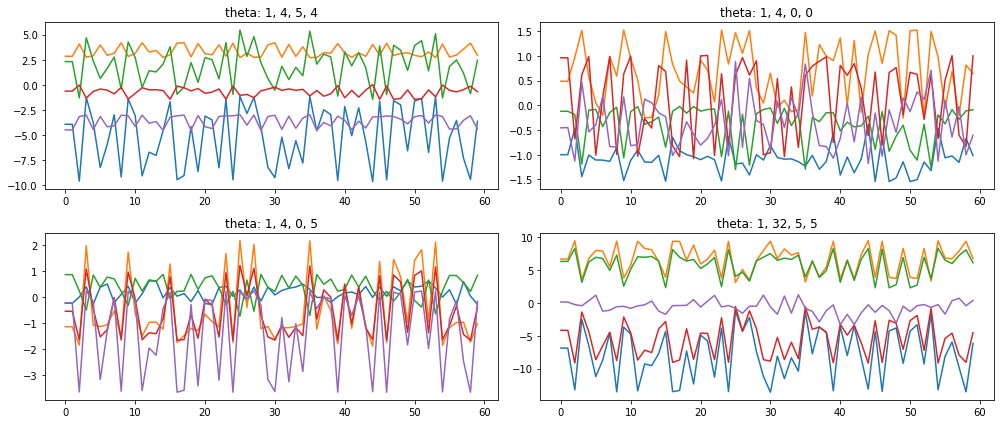

In [42]:
get_kernel_val(train_x, theta_ls)

## Plot the prediction result

In [43]:
beta_inv = 1

In [44]:
x = np.linspace(0, 2, 200)
y = np.empty(200)
std = np.empty(200)

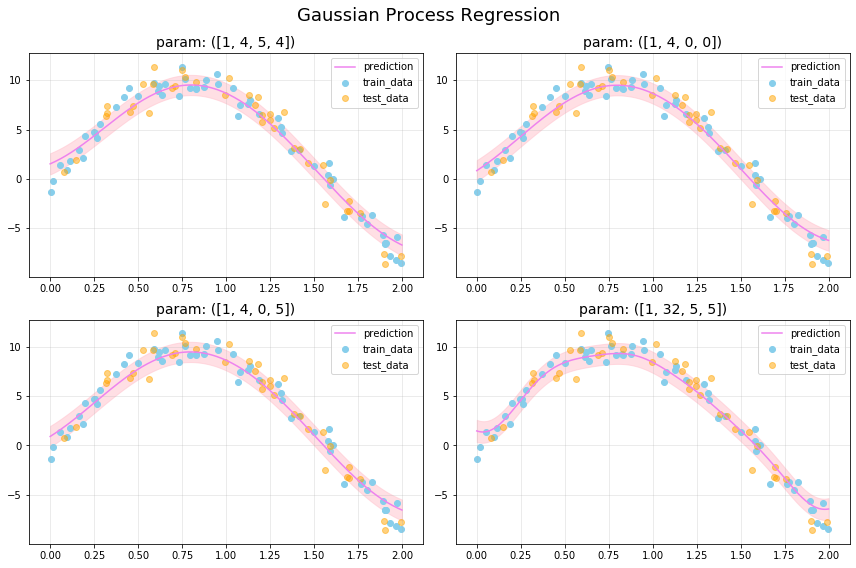

In [45]:
trainRMSE = []
testRMSE = []
f, pltax = plt.subplots(2, 2, figsize = (12, 8))
pltax = pltax.flatten()  
for i in range(4):
    c_inv = np.linalg.inv(exp_kernel(theta_ls[i], train_x, train_x) + beta_inv * np.identity(60))
    for j in range(200):
        K = exp_kernel(theta_ls[i], train_x, x[j])
        y[j] = K @ c_inv @ train_t

        C = exp_kernel(theta_ls[i], x[j], x[j]) + beta_inv
        std[j] = np.sqrt(C - np.linalg.multi_dot([K.T, c_inv, K]))
    
    train_y = np.empty(60)
    for m in range(60):
        K = exp_kernel(theta_ls[i], train_x, train_x[m])
        train_y[m] = K @ c_inv @ train_t
    trainRMSE.append(rmse(train_y, train_t))
    
    test_y = np.empty(40)
    for n in range(40):
        K = exp_kernel(theta_ls[i], train_x, test_x[n])
        test_y[n] = K @ c_inv @ train_t
    testRMSE.append(rmse(test_y, test_t))
    
    pltax[i].plot(x, y, 'violet', label = 'prediction')
    pltax[i].fill_between(x, y + std, y - std, color = 'pink', alpha = 0.5)
    pltax[i].scatter(train_x, train_t, color = 'skyblue', label = 'train_data')
    pltax[i].scatter(test_x, test_t, color = 'orange', alpha = 0.5, label = 'test_data')
    pltax[i].set_title(f'param: ({theta_ls[i]})', size = 14)
    pltax[i].grid('grey', alpha = 0.3)
    pltax[i].legend()
f.suptitle('Gaussian Process Regression', size = 18)
f.tight_layout()
f.subplots_adjust(top=0.9)
plt.show();

In [46]:
rmsetb = pd.DataFrame({
    'param': theta_ls,
    'train_RMSE': trainRMSE,
    'test_RMSE': testRMSE
})

In [47]:
print(tabulate(rmsetb, headers="keys", tablefmt = "fancy_grid", floatfmt=".4f"))

╒════╤═══════════════╤══════════════╤═════════════╕
│    │ param         │   train_RMSE │   test_RMSE │
╞════╪═══════════════╪══════════════╪═════════════╡
│  0 │ [1, 4, 5, 4]  │       1.0675 │      1.2825 │
├────┼───────────────┼──────────────┼─────────────┤
│  1 │ [1, 4, 0, 0]  │       1.0522 │      1.2988 │
├────┼───────────────┼──────────────┼─────────────┤
│  2 │ [1, 4, 0, 5]  │       1.0288 │      1.2861 │
├────┼───────────────┼──────────────┼─────────────┤
│  3 │ [1, 32, 5, 5] │       0.9640 │      1.2585 │
╘════╧═══════════════╧══════════════╧═════════════╛


## ARD  

$$\ln p(t|\theta) = -\frac{1}{2}|C_N|-\frac{1}{2}t^TC^{-1}_Nt-\frac{N}{2}\ln(2\pi) \\
\frac{\partial}{\partial \theta_i}\ln p(t|\theta) = -\frac{1}{2}\rm{Tr}\left(C^{-1}_N\frac{\partial C_N}{\partial \theta_i}\right) + \frac{1}{2}t^TC^{-1}_N\frac{\partial C_N}{\partial \theta_i}C^{-1}_Nt$$

In [16]:
def partial(C_inv, C_d, t):
    return (-np.trace(np.dot(C_inv, C_d)) + np.linalg.multi_dot([t.T, C_inv, C_d, C_inv, t])) / 2

$$
\begin{aligned}
\frac{\partial C_N}{\partial \eta_{0i}} &= \exp\left\{ -\frac{\eta_{1i}}{2}||{\mathrm X}_n-{\mathrm X}_m||^2\right\} \\
\frac{\partial C_N}{\partial \eta_{1i}} &= \eta_{0i} \left(-\frac{1}{2}||{\mathrm X}_n-{\mathrm X}_m||^2\right) \exp\left\{ -\frac{\eta_{1i}}{2}||{\mathrm X}_n-{\mathrm X}_m||^2\right\} \\
\frac{\partial C_N}{\partial \eta_{2i}} &= 1 \\
\frac{\partial C_N}{\partial \eta_{3i}} &= {\mathrm X}_n^T{\mathrm X}_m
\end{aligned}$$

In [34]:
param = [[3, 5, 6, 5]]
partial_ln = [0, 0, 0, 0]
eta = 0.00001
p_lnp = [0, 0, 0, 0]

In [35]:
while True:
    c_inv3 = np.linalg.inv(exp_kernel(param[-1], train_x, train_x) + beta_inv * np.identity(60))
    partial_ln[0] = partial(c_inv3, np.exp(-0.5 * param[-1][1] * np.subtract.outer(train_x, train_x)**2), train_t)
    partial_ln[1] = partial(c_inv3, param[-1][0] * -0.5 * np.subtract.outer(train_x, train_x)**2 * np.exp(-0.5 * param[-1][1] * np.subtract.outer(train_x, train_x)**2), train_t)
    partial_ln[2] = partial(c_inv3, np.ones((60, 60)), train_t)
    partial_ln[3] = partial(c_inv3, np.multiply.outer(train_x, train_x), train_t)
    for i in range(4):
        p_lnp[i] = -0.5 * np.trace(c_inv3.dot(partial_ln[i])) + 0.5 * train_t.T.dot(c_inv3).dot(partial_ln[i]).dot(c_inv3).dot(train_t)
        #p_lnp[i] = -0.5 * np.trace(c_inv3.dot(partial_ln[i])) + 0.5 * np.linalg.multi_dot([train_t.T, c_inv3, partial_ln[i], c_inv3, train_t])
    param.append([param_l + eta * partial_l for param_l, partial_l in zip(param[-1], p_lnp)])
    
    if np.max(np.abs(p_lnp)) < 6:
        break

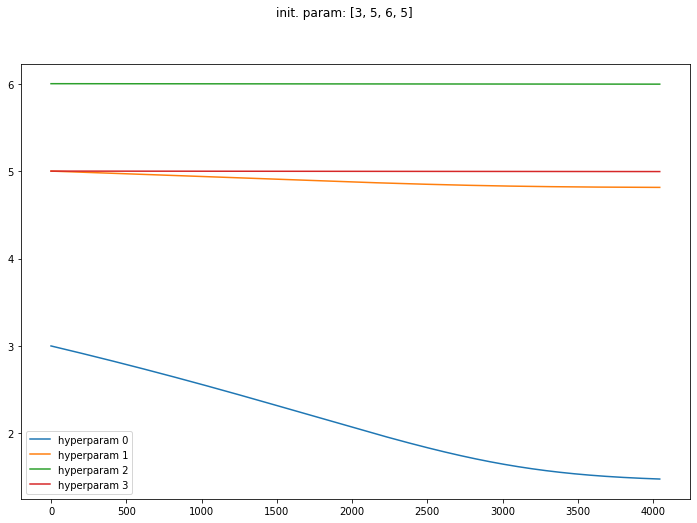

In [36]:
params = np.array(param)
plt.figure(figsize = (12, 8))
plt.suptitle(f"init. param: {param[0]}")
plt.plot(params[:, 0], label = 'hyperparam 0')
plt.plot(params[:, 1], label = 'hyperparam 1')
plt.plot(params[:, 2], label = 'hyperparam 2')
plt.plot(params[:, 3], label = 'hyperparam 3')
plt.legend()
plt.show();

In [37]:
param[-1]

[1.4776242838679945, 4.813795585003576, 5.994681670955796, 4.994736221528141]

In [25]:
np.full([10, 10], 1)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [28]:
a = [1, 2, 3]
b = [4, 5, 6]
[A+B for A, B in zip(a, b)]

[5, 7, 9]